### Data importation

In [1]:
import pandas as pd
import numpy as np
from random import sample
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from math import ceil
import datetime
from dateutil.relativedelta import relativedelta

import os

In [2]:
root_path = os.path.dirname(os.getcwd())
os.chdir(root_path)

### Load datasets
#### Transactions

In [3]:
# Load transactions
df_short = pd.read_csv('data/transaction_data_short.csv')
df_short = df_short.sort_values('date_order', ascending=False)
print(df_short.shape)
df_short.head(2)

(424254, 8)


,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
421357,2019-09-22,2019-09-24,1366829,971743,3.0912,21,online,3175
420871,2019-09-22,2019-09-24,2763020,971743,58.2498,21,online,3175


#### Relationships

In [106]:
# Load client relationships
df_rel = pd.read_csv('data/sales_client_relationship_dataset.csv')
print(df_rel.shape)
df_rel.head(2)

(170589, 2)


,client_id,quali_relation
0,188502,Difficult client
1,598816,Difficult client


<Axes: title={'center': 'Relationship distribution in all clients'}, xlabel='quali_relation'>

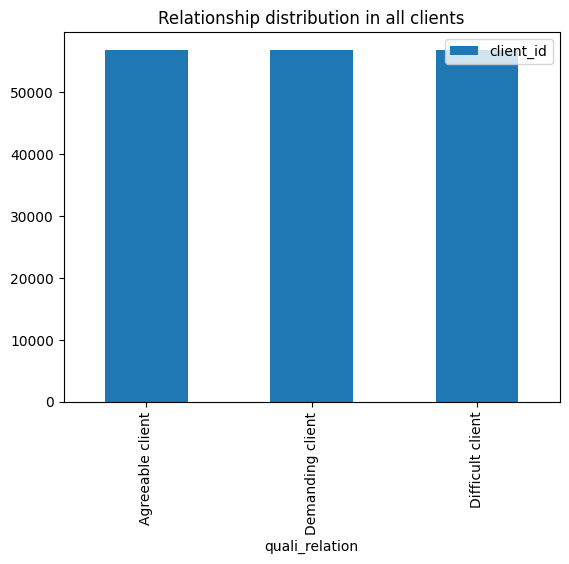

In [107]:
to_plot = df_rel.groupby('quali_relation').count().reset_index()
to_plot.plot.bar(x='quali_relation', y='client_id', title='Relationship distribution in all clients')

<Axes: title={'center': 'Relationship distribution in the sample'}, xlabel='quali_relation'>

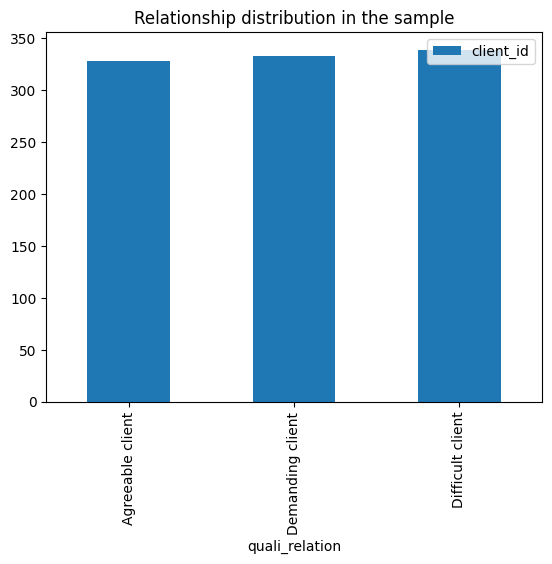

In [10]:
to_plot = df_rel[df_rel.client_id.isin(df_short.client_id)].groupby('quali_relation').count().reset_index()
to_plot.plot.bar(x='quali_relation', y='client_id', title='Relationship distribution in the sample')

The distribution is similar in our sample. 

### Building the sliding window
We retrieve the sales of a client in a sliding window.  
Args:  
    churn_date  
    client_id  
Returns:  
    quantity sold at each week during a 6 months period just before churn_date

In [5]:
churn_date = '2018-09-25'
churn_date = datetime.datetime.strptime(churn_date, '%Y-%m-%d')

client_id = 1272143
delta_train = 6 # size of the sliding box in month
delta_t_churn = 2 # number of weeks in the future taken into account in the churn definition (rule based)

In [6]:
# Select the right date range and the right client. 
sample_df = df_short[df_short.client_id==client_id].copy()
sample_df["date_order"] = pd.to_datetime(sample_df.date_order)
sample_df["date_invoice"] = pd.to_datetime(sample_df.date_order)

end_date = churn_date
start_date = end_date - relativedelta(months=6)
sample_df = sample_df[(sample_df.date_order>start_date) * (sample_df.date_order<churn_date)]

sample_df.head(2)

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
208233,2018-09-24,2018-09-24,1575356,1272143,30.050328,101,at the store,5297
210753,2018-09-24,2018-09-24,1144588,1272143,60.802800,3,at the store,5297


#### Features to put in the train/test dataset : 
- 5 : total sales_net in the last week, in the last 2 weeks, in the last month, in the last 3 months, in the last 6 months. 
- 5 : variance of sales_net over the same periods.
- 5 : mean time between two orders over the same periods of time
- 3 : percentage of usage of each channel
- 1 : relationship with the client
- 1 : number of different products bought
- 1 : std of the time between two orders  
- 1 : mean time difference between order and invoice  
= 18 features

In [210]:
# Add statistics on sales
delta_t_list = [1, 2, 4, 12, 24] # in week 
all_features = pd.DataFrame(data={'client_id': [client_id]})

for delta_t in delta_t_list:
    start_t = churn_date - relativedelta(weeks=delta_t)
    df = sample_df[sample_df.date_order>start_t][["sales_net", "client_id", "date_order", "invoice_order"]].copy()

    # Add average and standard deviation of sales_net
    features_delta_t = df[["sales_net", "client_id"]]\
        .groupby("client_id")\
        .agg(['mean', 'std'])\
        .rename(columns={'mean': f'mean_{delta_t}', 'std': f'std_{delta_t}'})['sales_net']\
        .reset_index()\

    all_features[[f'mean_{delta_t}', f'std_{delta_t}']] = features_delta_t[[f'mean_{delta_t}', f'std_{delta_t}']]

    # Add mean time between two orders
    df_time_diff = df[['date_order']].sort_values('date_order', ascending=False).groupby('date_order').sum().reset_index().copy()
    df_time_diff["delta_time"] = df_time_diff.date_order - df_time_diff.date_order.shift(1)

    all_features[f'mean_delta_time_{delta_t}'] = df_time_diff.delta_time.mean()
    if delta_t==24:
        # Add the standard deviation of the time between two orders
        all_features[f'std_delta_time'] = df_time_diff.delta_time.std()

all_features.head()

,client_id,mean_1,std_1,mean_delta_time_1,mean_2,std_2,mean_delta_time_2,mean_4,std_4,mean_delta_time_4,mean_12,std_12,mean_delta_time_12,mean_24,std_24,mean_delta_time_24,std_delta_time
0,1272143,81.126756,174.094633,1 days 16:00:00,173.00053,246.998732,1 days 12:00:00,203.398521,310.483265,1 days 15:00:00,162.714686,274.748131,1 days 13:07:55.471698113,168.129588,289.247436,1 days 14:40:46.601941747,1 days 02:04:55.750301142


In [212]:
# Add channel ratios
channel_list = ['at the store', 'by phone', 'online', 'other', 'during the visit of a sales rep']
for channel in channel_list:
    all_features[f'{channel}'] = (sample_df.order_channel==channel).sum()/len(sample_df)

# Add relationship with client
all_features["relationship"] = df_rel[df_rel.client_id==client_id].iloc[0,:].at['quali_relation']

# Add number of products bought
all_features["n_products"] = sample_df.product_id.nunique()

# Add mean time between order and invoice
all_features["mean_diff_order_invoice"] = (sample_df.date_invoice - sample_df.date_order).mean()

all_features.head()

,client_id,mean_1,std_1,mean_delta_time_1,mean_2,std_2,mean_delta_time_2,mean_4,std_4,mean_delta_time_4,...,mean_delta_time_24,std_delta_time,at the store,by phone,online,other,during the visit of a sales rep,relationship,n_products,mean_diff_order_invoice
0,1272143,81.126756,174.094633,1 days 16:00:00,173.00053,246.998732,1 days 12:00:00,203.398521,310.483265,1 days 15:00:00,...,1 days 14:40:46.601941747,1 days 02:04:55.750301142,0.478666,0.521334,0.0,0.0,0.0,Demanding client,556,1 days 07:26:51.481768813


In [ ]:
# Add standard deviation of the time between two orders
all_features["n_products"]

In [220]:
pd.DataFrame(data={'diff': sample_df.date_invoice - sample_df.date_order}).sort_values('diff')

,diff
208233,0 days
145566,0 days
146240,0 days
147293,0 days
145896,0 days
...,...
154225,50 days
211423,56 days
211469,56 days
237219,69 days


In [222]:
sample_df.loc[261662, :]

date_order       2018-04-24 00:00:00
date_invoice     2018-12-14 00:00:00
product_id                   2019872
client_id                    1272143
sales_net                  -248.4552
quantity                           3
order_channel               by phone
branch_id                       1102
Name: 261662, dtype: object

In [7]:
from src.plot_utils import plot_ts

In [8]:
plot_ts(sample_df)